In [3]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph,START,END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from typing import Annotated
from langchain_experimental.utilities import PythonREPL

In [4]:
load_dotenv()

True

In [5]:
openai_model=ChatOpenAI(model="gpt-4")

In [6]:
openai_model.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-86381537-f7e0-48eb-a2bf-727414fa07b5-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [7]:

def add_numbers(state):
    result=state["num1"]+state["num2"]
    print(f"additional result: {result}")
    return Command(goto="multiply",update={"sum":result})

In [8]:
state={"num1":1, "num2":2}

In [9]:

add_numbers(state)

additional result: 3


Command(update={'sum': 3}, goto='multiply')

In [14]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return 

@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return 

In [15]:

model_with_tool=openai_model.bind_tools([transfer_to_multiplication_expert])

In [16]:
ai_message=model_with_tool.invoke("hi how are you?")

In [17]:
ai_message.tool_calls

[]

In [19]:

ai_message=model_with_tool.invoke("what's (3 + 5) * 12. Provide me the output")

In [20]:
ai_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qsUpNrJYJlHqc3UNVHiDdZKa', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 58, 'total_tokens': 70, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-769cb22b-422e-458b-9ec5-2180c3bb4245-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {}, 'id': 'call_qsUpNrJYJlHqc3UNVHiDdZKa', 'type': 'tool_call'}], usage_metadata={'input_tokens': 58, 'output_tokens': 12, 'total_tokens': 70, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [21]:
ai_message.tool_calls

[{'name': 'transfer_to_multiplication_expert',
  'args': {},
  'id': 'call_qsUpNrJYJlHqc3UNVHiDdZKa',
  'type': 'tool_call'}]

In [22]:
def additional_expert(state:MessagesState)-> Command[Literal["multiplication_expert", "__end__"]]:
    
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    
    ai_msg = openai_model.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

In [ ]:
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:
    
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = openai_model.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [25]:
graph=StateGraph(MessagesState)

In [26]:
graph.add_node("additional_expert",additional_expert)
graph.add_node("multiplication_expert",multiplication_expert)


In [27]:
graph.add_edge(START, "additional_expert")

In [28]:
app=graph.compile()

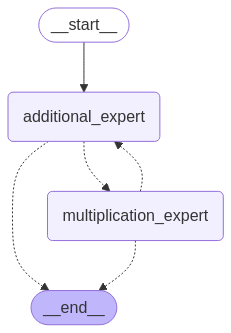

In [29]:

app=graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [30]:
app.invoke({"messages":[("user","what's (3 + 5) * 12. Provide me the output")]})

{'messages': [HumanMessage(content="what's (3 + 5) * 12. Provide me the output", additional_kwargs={}, response_metadata={}, id='0700ab9d-690f-4fa1-9d5a-36ae520021ee'),
  AIMessage(content='The first part of the calculation is my field of expertise where I calculate the addition of 3 and 5 which is 8. For the multiplication of this result with 12, I need to pass it to the multiplication expert.', additional_kwargs={'tool_calls': [{'id': 'call_MlLORE5eGvWsm6Z2CsxuCDtE', 'function': {'arguments': '8 * 12', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 86, 'total_tokens': 150, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs